In [1]:
import os
import cv2
import glob
import h5py
import scipy
import pickle
import numpy as np
from PIL import Image
import scipy.io as io
from itertools import islice
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
from sortedcontainers import SortedDict
from scipy.ndimage.filters import gaussian_filter 
%matplotlib inline

In [2]:
def get_img_pathes(path_sets):
    """
    Return all images from all pathes in 'path_sets'
    """
    img_pathes = []
    for path in path_sets:
        for img_path in glob.glob(os.path.join(path, '*.jpg')):
            img_pathes.append(img_path)
    return img_pathes


def save_computed_density(density_map, out_path):
    """
    Save density map to h5py format
    """
    with h5py.File(out_path, 'w') as hf:
        hf['density'] = density_map
        

def compute_sigma(gt_count, distance=None, min_sigma=1, method=1, fixed_sigma=15):
    """
    Compute sigma for gaussian kernel with different methods :
    * method = 1 : sigma = (sum of distance to 3 nearest neighbors) / 10
    * method = 2 : sigma = distance to nearest neighbor
    * method = 3 : sigma = fixed value
    ** if sigma lower than threshold 'min_sigma', then 'min_sigma' will be used
    ** in case of one point on the image sigma = 'fixed_sigma'
    """    
    if gt_count > 1 and distance is not None:
        if   method == 1:
            sigma = np.mean(distance[1:4])*0.1
        elif method == 2:
            sigma = distance[1]
        elif method == 3:
            sigma = fixed_sigma
    else:
        sigma = fixed_sigma
    if sigma < min_sigma:
        sigma = min_sigma
    return sigma


def find_closest_key(sorted_dict, key):
    """
    Find closest key in sorted_dict to 'key'
    """
    keys = list(islice(sorted_dict.irange(minimum=key), 1))
    keys.extend(islice(sorted_dict.irange(maximum=key, reverse=True), 1))
    return min(keys, key=lambda k: abs(key - k))


def gaussian_filter_density(non_zero_points, map_h, map_w, distances=None, kernels_dict=None, min_sigma=2, method=1, const_sigma=15):
    """
    Fast gaussian filter implementation : using precomputed distances and kernels
    """
    gt_count = non_zero_points.shape[0]
    density_map = np.zeros((map_h, map_w), dtype=np.float32)

    for i in range(gt_count):
        point_y, point_x = non_zero_points[i]
        sigma = compute_sigma(gt_count, distances[i], min_sigma=min_sigma, method=method, fixed_sigma=const_sigma)
        closest_sigma = find_closest_key(kernels_dict, sigma)
        kernel = kernels_dict[closest_sigma]
        full_kernel_size = kernel.shape[0]
        kernel_size = full_kernel_size // 2

        min_img_x = max(0, point_x-kernel_size)
        min_img_y = max(0, point_y-kernel_size)
        max_img_x = min(point_x+kernel_size+1, map_h - 1)
        max_img_y = min(point_y+kernel_size+1, map_w - 1)

        kernel_x_min = kernel_size - point_x if point_x <= kernel_size else 0
        kernel_y_min = kernel_size - point_y if point_y <= kernel_size else 0
        kernel_x_max = kernel_x_min + max_img_x - min_img_x
        kernel_y_max = kernel_y_min + max_img_y - min_img_y

        density_map[min_img_x:max_img_x, min_img_y:max_img_y] += kernel[kernel_x_min:kernel_x_max, kernel_y_min:kernel_y_max]
    return density_map


def get_gt_dots(mat_path, img_height, img_width):
    """
    Load Matlab file with ground truth labels and save it to numpy array.
    ** cliping is needed to prevent going out of the array
    """
    mat = io.loadmat(mat_path)
    gt = mat["image_info"][0,0][0,0][0].astype(np.float32).round().astype(int)
    gt[:,0] = gt[:,0].clip(0, img_width - 1)
    gt[:,1] = gt[:,1].clip(0, img_height - 1)
    return gt


def set_circles_on_img(image, bbox_list, circle_size=2):
    """
    Set circles on images at centers of bboxes in bbox_list
    """
    for bbox in bbox_list:
        cv2.circle(image, (bbox[0], bbox[1]), circle_size, (255, 0, 0), -1)
    return image


def generate_gaussian_kernels(out_kernels_path='gaussian_kernels.pkl', round_decimals = 3, sigma_threshold = 4, sigma_min=0, sigma_max=20, num_sigmas=801):
    """
    Computing gaussian filter kernel for sigmas in linspace(sigma_min, sigma_max, num_sigmas) and saving 
    them to dict.     
    """
    kernels_dict = dict()
    sigma_space = np.linspace(sigma_min, sigma_max, num_sigmas)
    for sigma in tqdm_notebook(sigma_space):
        sigma = np.round(sigma, decimals=round_decimals) 
        kernel_size = np.ceil(sigma*sigma_threshold).astype(np.int)

        img_shape  = (kernel_size*2+1, kernel_size*2+1)
        img_center = (img_shape[0]//2, img_shape[1]//2)

        arr = np.zeros(img_shape)
        arr[img_center] = 1

        arr = scipy.ndimage.filters.gaussian_filter(arr, sigma, mode='constant') 
        kernel = arr / arr.sum()
        kernels_dict[sigma] = kernel
        
    print(f'Computed {len(sigma_space)} gaussian kernels. Saving them to {out_kernels_path}')

    with open(out_kernels_path, 'wb') as f:
        pickle.dump(kernels_dict, f)
        
        
def compute_distances(out_dist_path='distances_dict.pkl', Shanghai_root_path='./', n_neighbors = 4, leafsize=1024):
    distances_dict = dict()
    full_img_pathes = glob.glob(f'{Shanghai_root_path}*/*/images/*.jpg')

    for full_img_path in tqdm_notebook(full_img_pathes):
        mat_path = full_img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_')

        img = plt.imread(full_img_path)
        non_zero_points = get_gt_dots(mat_path, *img.shape[0:2])

        tree = scipy.spatial.KDTree(non_zero_points.copy(), leafsize=leafsize)  # build kdtree
        distances, _ = tree.query(non_zero_points, k=n_neighbors)  # query kdtree

        distances_dict[full_img_path] = distances
        
    print(f'Distances computed for {len(full_img_pathes)}. Saving them to {out_dist_path}')

    with open(out_dist_path, 'wb') as f:
        pickle.dump(distances_dict, f)

In [3]:
precomputed_kernels_path = 'gaussian_kernels.pkl'

# uncomment to generate and save dict with kernel sizes
generate_gaussian_kernels(precomputed_kernels_path, round_decimals=3, sigma_threshold=4, sigma_min=0, sigma_max=20, num_sigmas=801)
    
with open(precomputed_kernels_path, 'rb') as f:
    kernels_dict = pickle.load(f)
    kernels_dict = SortedDict(kernels_dict)


Computed 801 gaussian kernels. Saving them to gaussian_kernels.pkl


In [4]:
precomputed_distances_path = 'distances_dict.pkl'

# uncomment to generate and save dict with distances 
compute_distances(out_dist_path=precomputed_distances_path, Shanghai_root_path='/home/vladislav.leketush/ssd_data/Crowd_data/ShanghaiTech/ShanghaiTech/')
    
with open(precomputed_distances_path, 'rb') as f:
    distances_dict = pickle.load(f)


Distances computed for 1198. Saving them to distances_dict.pkl


In [5]:
# generate GT for part A
data_root  = '/home/vladislav.leketush/ssd_data/Crowd_data/ShanghaiTech/ShanghaiTech/part_A/'
img_pathes = glob.glob(f'{data_root}*/images/*.jpg')
map_out_folder = 'maps_adaptive_kernel/'
min_sigma = 2  ## can be set 0
method = 1

for full_img_path in tqdm_notebook(img_pathes):
    data_folder, img_path = full_img_path.split('images')
    mat_path = full_img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_')
    
    # load img and map
    img = Image.open(full_img_path)
    width, height = img.size
    gt_points = get_gt_dots(mat_path, height, width)
    
    distances = distances_dict[full_img_path]
    density_map = gaussian_filter_density(gt_points, height, width, distances, kernels_dict, min_sigma=min_sigma, method=method)
    
    curr_map_out_folder = data_folder + map_out_folder
    gt_out_path = curr_map_out_folder + img_path.strip('/').replace('.jpg', '.h5')
    
#     #plt.imshow(img)
#     plt.imshow(density_map, alpha=1)
#     plt.show()
#     break
    if not os.path.isdir(curr_map_out_folder):
        print('creating ' + curr_map_out_folder)
        os.makedirs(curr_map_out_folder)
    save_computed_density(density_map, gt_out_path)

In [6]:
# generate GT for part B
data_root  = '/home/vladislav.leketush/ssd_data/Crowd_data/ShanghaiTech/ShanghaiTech/part_B/'
img_pathes = glob.glob(f'{data_root}*/images/*.jpg')
map_out_folder = 'maps_fixed_kernel/'
min_sigma = 2
method = 3
const_sigma=15

for full_img_path in tqdm_notebook(img_pathes):
    data_folder, img_path = full_img_path.split('images')
    mat_path = full_img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_')
    
    # load img and map
    img = Image.open(full_img_path)
    width, height = img.size
    gt_points = get_gt_dots(mat_path, height, width)
    
    distances = distances_dict[full_img_path]
    density_map = gaussian_filter_density(gt_points, height, width, distances, kernels_dict, min_sigma=min_sigma, method=method,const_sigma=const_sigma)
    
    curr_map_out_folder = data_folder + map_out_folder
    gt_out_path = curr_map_out_folder + img_path.strip('/').replace('.jpg', '.h5')
    
#     #plt.imshow(img)
#     plt.imshow(density_map, alpha=1)
#     plt.show()
#     break
    if not os.path.isdir(curr_map_out_folder):
        print('creating ' + curr_map_out_folder)
        os.makedirs(curr_map_out_folder)
    save_computed_density(density_map, gt_out_path)

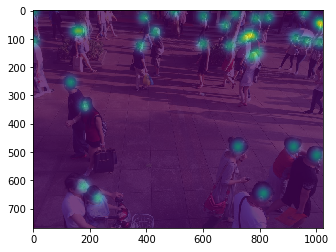

In [7]:
plt.imshow(img)
plt.imshow(density_map, alpha=0.75)
plt.show()